In [1]:
%%time
# Ignore this block -- it's for the documentation build
try:
    import os, sys
    sys.path.insert(1, os.path.abspath('/home/runner/work/psi4/psi4/code/objdir/stage//usr/local/psi4/lib/'))
except ImportError:
    pass

# This is the important part
import psi4

CPU times: user 374 ms, sys: 109 ms, total: 484 ms
Wall time: 709 ms


In [2]:
%%time
psi4.set_output_file('output.dat', False)


CPU times: user 1.35 ms, sys: 0 ns, total: 1.35 ms
Wall time: 2.88 ms


PosixPath('output.dat')

In [4]:
# Measure execution time of the computation
%time

# Sample HF/cc-pVDZ H2O Computation
import psi4

psi4.set_memory('500 MB')

# Define the water molecule geometry
h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

# Perform the energy calculation
psi4.energy('scf/cc-pvdz')


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.58 µs


-76.0266327350902

In [6]:
%%time
#! Sample UHF/6-31G** CH2 Computation

R = 1.075
A = 133.93

ch2 = psi4.geometry("""
0 3
C
H 1 {0}
H 1 {0} 2 {1}
""".format(R, A)
)

psi4.set_options({'reference': 'uhf'})
psi4.energy('scf/6-31g**')

CPU times: user 283 ms, sys: 11.6 ms, total: 295 ms
Wall time: 312 ms


-38.92533462893707

In [7]:
%%time
psi4.set_options({'reference': 'rhf'})
psi4.optimize('scf/cc-pvdz', molecule=h2o)

Optimizer: Optimization complete!
CPU times: user 857 ms, sys: 44.8 ms, total: 901 ms
Wall time: 932 ms


-76.02703272937481

In [8]:
%%time 
scf_e, scf_wfn = psi4.frequency('scf/cc-pvdz', molecule=h2o, return_wfn=True)

CPU times: user 1.01 s, sys: 42.6 ms, total: 1.05 s
Wall time: 1.09 s


In [9]:
%%time
# Example SAPT computation for ethene*ethyne (*i.e.*, ethylene*acetylene).
# Test case 16 from S22 Database

dimer = psi4.geometry("""
0 1
C   0.000000  -0.667578  -2.124659
C   0.000000   0.667578  -2.124659
H   0.923621  -1.232253  -2.126185
H  -0.923621  -1.232253  -2.126185
H  -0.923621   1.232253  -2.126185
H   0.923621   1.232253  -2.126185
--
0 1
C   0.000000   0.000000   2.900503
C   0.000000   0.000000   1.693240
H   0.000000   0.000000   0.627352
H   0.000000   0.000000   3.963929
units angstrom
""")

CPU times: user 1.12 ms, sys: 13 µs, total: 1.13 ms
Wall time: 1.15 ms


In [10]:
%%time
psi4.set_options({'scf_type': 'df',
                  'freeze_core': True})

psi4.energy('sapt0/jun-cc-pvdz', molecule=dimer)

CPU times: user 3.93 s, sys: 272 ms, total: 4.2 s
Wall time: 4.33 s


-0.0022355823909805178

In [11]:
%time
#! Example potential energy surface scan and CP-correction for Ne2

ne2_geometry = """
Ne
--
Ne 1 {0}
"""

Rvals = [2.5, 3.0, 4.0]

psi4.set_options({'freeze_core': True})

# Initialize a blank dictionary of counterpoise corrected energies
# (Need this for the syntax below to work)

ecp = {}

for R in Rvals:
    ne2 = psi4.geometry(ne2_geometry.format(R))
    ecp[R] = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ne2)

# Prints to screen
print("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    print("            {:3.1f}                        {:1.6f}".format(R, e))

# Prints to output.dat
psi4.core.print_out("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
psi4.core.print_out("          R [Ang]                 E_int [kcal/mol]       \n")
psi4.core.print_out("---------------------------------------------------------\n")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    psi4.core.print_out("            {:3.1f}                        {:1.6f}\n".format(R, e))

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs
CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies


          R [Ang]                 E_int [kcal/mol]       
---------------------------------------------------------
            2.5                        0.758605
            3.0                        0.015968
            4.0                        -0.016215


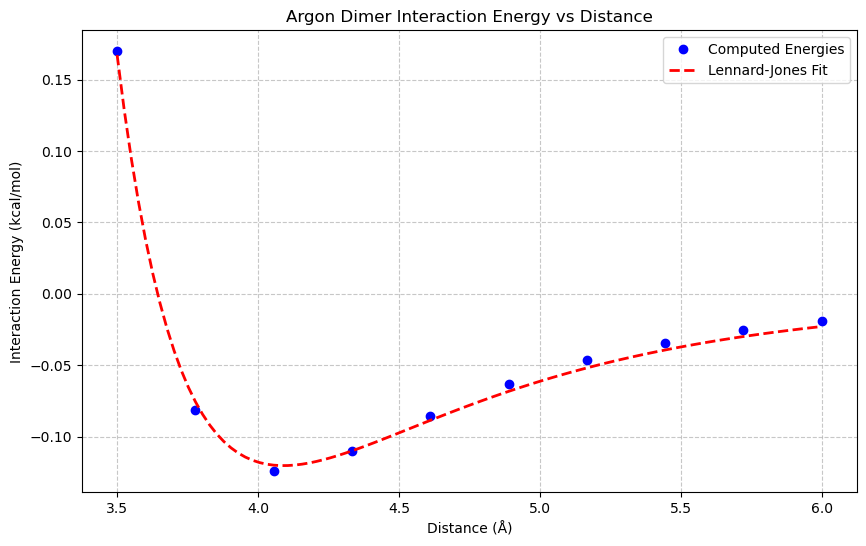


CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies

          R [Ang]                 E_int [kcal/mol]       
---------------------------------------------------------
            3.5                        0.169820
            3.8                        -0.081140
            4.1                        -0.124283
            4.3                        -0.109920
            4.6                        -0.085267
            4.9                        -0.063321
            5.2                        -0.046452
            5.4                        -0.034117
            5.7                        -0.025247
            6.0                        -0.018882


In [14]:
# Import necessary libraries
import psi4
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

# Define the Lennard-Jones potential function
def lj(r, sigma, eps):
    return 4 * eps * ((sigma / r)**12 - (sigma / r)**6)

# Define geometry for Argon dimer and initialize distances
ar2_geometry = """
Ar
--
Ar 1 {0}
"""
distances = np.linspace(3.5, 6.0, num=10)  # 10 points from 3.5 to 6.0 Å

# Set Psi4 options
psi4.set_options({'freeze_core': True})

# Calculate interaction energies at each distance
interaction_energies = []
for R in distances:
    ar2 = psi4.geometry(ar2_geometry.format(R))
    energy = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ar2)
    interaction_energies.append(energy * psi4.constants.hartree2kcalmol)  # Convert to kcal/mol

# Fit data to the Lennard-Jones potential
initial_guess = [3.8, 0.1]  # Initial guess for sigma and epsilon
params, covariance = curve_fit(lj, distances, interaction_energies, p0=initial_guess)
sigma_fit, eps_fit = params

# Create the Figures directory if it doesn't exist
os.makedirs('Figures', exist_ok=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(distances, interaction_energies, 'bo', label='Computed Energies')  # Computed points
smooth_distances = np.linspace(3.5, 6.0, 100)  # Smooth line for fit
plt.plot(smooth_distances, lj(smooth_distances, sigma_fit, eps_fit), 'r--', label='Lennard-Jones Fit', linewidth=2)
plt.xlabel('Distance (Å)')
plt.ylabel('Interaction Energy (kcal/mol)')
plt.title('Argon Dimer Interaction Energy vs Distance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Save and show the plot
plt.savefig('Figures/argon_dimer_energy_vs_distance.png', dpi=300)
plt.show()

# Print computed energies for each distance
print("\nCP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for i, R in enumerate(distances):
    print(f"            {R:.1f}                        {interaction_energies[i]:.6f}")


In [ ]:
Interpretation: 

As the distance decreases, the interaction energy becomes more negative, indicating stronger attraction between the two Argon atoms.
At very small distances (close contact), the repulsive forces (not captured here, but implied in the potential) would dominate and the energy would increase again. 
The minimum of the potential curve represents the most stable configuration of the Argon dimer.
This plot visually confirms the van der Waals behavior of Argon atoms and how well the Lennard-Jones potential fits the observed interaction energies.